# Data Load

In [1]:
!curl -O http://mattmahoney.net/dc/text8.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29.8M  100 29.8M    0     0  17.0M      0  0:00:01  0:00:01 --:--:-- 17.0M


In [2]:
!unzip text8.zip

Archive:  text8.zip
  inflating: text8                   


# Dataset

In [1]:
import re
from collections import Counter
from tqdm.notebook import tqdm
import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import time
import torch.optim as optim

In [2]:
class W2VCorpus:
    def __init__(self, file_path, max_vocab_size: int = 40_000, min_word_freq: int = 20):
        self.max_corp_size = max_vocab_size
        self.min_word_freq = min_word_freq
        self.W = None
        self.P = None
        self.pairs = None

        corpus = []

        with open(file_path, 'r') as file:
            for line in file:
                corpus += line.split()

        self.corpus = corpus

        words_freq = Counter(corpus).most_common(self.max_corp_size)
        words_freq = list(filter(lambda word: word[1] > self.min_word_freq, words_freq))
        
        print(f'len vocab: {len(words_freq)}')
        self.vocabulary = [key for key, _ in words_freq]
        self.vocabulary.append('<PAD>')
        self.vocabulary.append('<UNK>')
        
        self.ind_to_word = dict(enumerate(self.vocabulary))
        self.word_to_ind = {value: key for key, value in self.ind_to_word.items()}
        self.vocabulary = set(self.vocabulary)  # very fast search

    def make_dataset(self, window_size=2):
        """take corpus and make positive examples for skipgram or CBOW
           like: [1234], [[3333, 1111, 2222, 4444]]"""
        W = []
        P = []
        for ind, word in tqdm(enumerate(self.corpus), total=len(self.corpus)):
            if word not in self.vocabulary:
                word = '<UNK>'
            start_index = max(0, ind - window_size)
            end_index = min(len(self.corpus), ind + window_size + 1)
            content_words = self.corpus[start_index : end_index]

            center_word_pos = window_size
            if ind - window_size < 0:  # start of sequence
                center_word_pos += ind - window_size
            
            # deletes central word from context
            del content_words[center_word_pos]
            content_words = list(
                map(
                    lambda x: x if x in self.vocabulary else '<UNK>', 
                    content_words
                    )
                )
            while len(content_words) < 2 * window_size:
                content_words.append('<PAD>')

            W.append(self.word_to_ind[word])
            P.append(list(map(lambda x: self.word_to_ind[x], content_words)))
        self.W = W
        self.P = P
        del self.corpus    
        
    def make_pairs(self):
        """[1234], [[3333, 1111, 2222, 4444]] ->
            [1234, 3333],
            [1234, 1111],
            ....
            [9999, 1982],
        """
        pairs = []
        for w, p in tqdm(zip(self.W, self.P), total=len(self.W)):
            for current_p in p:
                if self.ind_to_word[current_p] != '<PAD>':
                    pairs.append((w, current_p))
        # self.pairs = pairs
        # remove duplicated pairs
        self.pairs = list(set(pairs))
        del self.W
        del self.P

In [3]:
corpus = W2VCorpus('text8')

len vocab: 30964


In [4]:
corpus.make_dataset(2)

  0%|          | 0/17005207 [00:00<?, ?it/s]

In [5]:
corpus.P[:5]

[[3080, 11, 30964, 30964],
 [5233, 11, 5, 30964],
 [5233, 3080, 5, 194],
 [3080, 11, 194, 1],
 [11, 5, 1, 3133]]

In [6]:
corpus.make_pairs()

  0%|          | 0/17005207 [00:00<?, ?it/s]

In [7]:
corpus.pairs[:5]

[(6541, 30), (2836, 10822), (462, 1900), (308, 1433), (836, 7968)]

In [8]:
import gc
gc.collect()

17005246

In [9]:
class W2VDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs

    def __getitem__(self, item):
        return {
            'word': torch.tensor(self.pairs[item][0]),
            'context': torch.tensor(self.pairs[item][1])
            }

    def __len__(self):
        return len(self.pairs)

In [10]:
dataset = W2VDataset(corpus.pairs)
loader = DataLoader(dataset, batch_size=1650, shuffle=True)

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [12]:
for batch in loader:
    print(batch)
    break

{'word': tensor([10799, 12566, 19847,  ...,  1475,  9885, 26298]), 'context': tensor([ 1058,  6468,   851,  ...,   353, 19130, 30965])}


In [13]:
len(loader), len(dataset)

(6659, 10985969)

# Model

In [14]:
class W2VModel(nn.Module):
    def __init__(self, vocab_size, emb_dim):
        super(W2VModel, self).__init__()
        self.vocab_size = vocab_size
        self.emb_dim = emb_dim

        self.emb = nn.Embedding(self.vocab_size, self.emb_dim)
        self.decoder = nn.Linear(self.emb_dim, self.vocab_size)

        self.init_emb()

    def forward(self, x):
        x = self.emb(x)
        return self.decoder(x)

    def init_emb(self):
        """
        init the weight as original word2vec do.
        """
        initrange = 0.5 / self.emb_dim
        self.emb.weight.data.uniform_(-initrange, initrange)
        self.decoder.weight.data.uniform_(0, 0)

In [15]:
def train(epoch: int,
          model: nn.Module,
          training_data_loader: DataLoader,
          criterion: nn.Module,
          optimizer: torch.optim.Optimizer,
          device: str):
    epoch_loss = 0
    for iteration, batch in tqdm(enumerate(training_data_loader, 1), total=len(training_data_loader)):
        input, target = batch['word'].to(device), batch['context'].to(device)

        optimizer.zero_grad()
        loss = criterion(model(input), target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

        if iteration % 500 == 0:
            print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(training_data_loader), loss.item()))

    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(training_data_loader)))
    return epoch_loss / len(training_data_loader)

In [16]:
model = W2VModel(len(corpus.vocabulary), 300).to(device)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []


for epoch in range(3):
    train_loss = train(epoch, model, loader, criterion, optimizer, device)

    train_losses.append(train_loss)

  0%|          | 0/6659 [00:00<?, ?it/s]

===> Epoch[0](500/6659): Loss: 9.2776
===> Epoch[0](1000/6659): Loss: 9.2821
===> Epoch[0](1500/6659): Loss: 9.2576
===> Epoch[0](2000/6659): Loss: 9.2253
===> Epoch[0](2500/6659): Loss: 9.2364
===> Epoch[0](3000/6659): Loss: 9.1779
===> Epoch[0](3500/6659): Loss: 9.1224
===> Epoch[0](4000/6659): Loss: 9.1470
===> Epoch[0](4500/6659): Loss: 9.2103
===> Epoch[0](5000/6659): Loss: 9.1634
===> Epoch[0](5500/6659): Loss: 9.1434
===> Epoch[0](6000/6659): Loss: 9.1595
===> Epoch[0](6500/6659): Loss: 9.1063
===> Epoch 0 Complete: Avg. Loss: 9.2382


  0%|          | 0/6659 [00:00<?, ?it/s]

===> Epoch[1](500/6659): Loss: 9.0243
===> Epoch[1](1000/6659): Loss: 9.0130
===> Epoch[1](1500/6659): Loss: 9.0076
===> Epoch[1](2000/6659): Loss: 8.9591
===> Epoch[1](2500/6659): Loss: 8.9887
===> Epoch[1](3000/6659): Loss: 8.9665
===> Epoch[1](3500/6659): Loss: 8.9804
===> Epoch[1](4000/6659): Loss: 8.9296
===> Epoch[1](4500/6659): Loss: 8.9296
===> Epoch[1](5000/6659): Loss: 9.0313
===> Epoch[1](5500/6659): Loss: 8.9082
===> Epoch[1](6000/6659): Loss: 8.9677
===> Epoch[1](6500/6659): Loss: 9.0416
===> Epoch 1 Complete: Avg. Loss: 8.9966


  0%|          | 0/6659 [00:00<?, ?it/s]

===> Epoch[2](500/6659): Loss: 8.8678
===> Epoch[2](1000/6659): Loss: 8.8066
===> Epoch[2](1500/6659): Loss: 8.8272
===> Epoch[2](2000/6659): Loss: 8.8936
===> Epoch[2](2500/6659): Loss: 8.8889
===> Epoch[2](3000/6659): Loss: 8.7669
===> Epoch[2](3500/6659): Loss: 8.8003
===> Epoch[2](4000/6659): Loss: 8.9279
===> Epoch[2](4500/6659): Loss: 8.7880
===> Epoch[2](5000/6659): Loss: 8.8420
===> Epoch[2](5500/6659): Loss: 8.8461
===> Epoch[2](6000/6659): Loss: 8.8594
===> Epoch[2](6500/6659): Loss: 8.8722
===> Epoch 2 Complete: Avg. Loss: 8.8597


In [17]:
torch.save(model, 'w2v_model.torch')

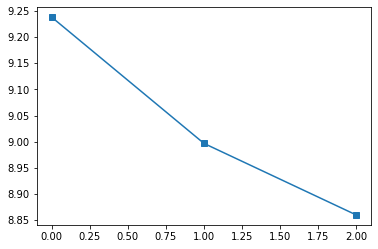

In [18]:
import matplotlib.pyplot as plt
plt.plot(train_losses, marker='s')

# Most Similar

In [17]:
model = torch.load('w2v_model.torch', map_location=torch.device('cpu'))

In [18]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import pandas as pd

In [19]:
result = dict()
for key, value in tqdm(corpus.word_to_ind.items()):
    preds = model.emb.weight[value]
    result[key] = preds.cpu().detach().numpy()

  0%|          | 0/30966 [00:00<?, ?it/s]

In [20]:
word = 'gun'

In [21]:
df = dict()
for key, value in tqdm(result.items()):
    distance = cosine_similarity(result[word].reshape(1, -1), value.reshape(1, -1))[0][0]
    df[key] = distance

  0%|          | 0/30966 [00:00<?, ?it/s]

In [22]:
most_similar = pd.DataFrame(df, index=[0]).T.reset_index().sort_values(0, ascending=False).head(15)
most_similar.columns = ['word', 'distance']
most_similar

,word,distance
1746,gun,1.000000
2699,guns,0.722937
9136,pistol,0.707362
4115,rifle,0.698505
2267,weapon,0.687570
5188,cannon,0.683328
20161,revolver,0.683287
12016,carbine,0.678511
6072,firearms,0.673854
6055,rifles,0.665542
